# Turbulence generator parameters visualization
This code generates animation showing how velocity inlet profile changes over time.

## Theory
RMS of a sine wave (https://en.wikipedia.org/wiki/Root_mean_square)    
$$y = A_1 sin(2 \pi f t) \rightarrow RMS = \frac{A_1}{\sqrt{2}}$$
Total RMS of multiple sine modes:
$$RMS_{total} \equiv \sqrt{RMS_1^2 + RMS_2^2 + ... + RMS_n^2} =  \sqrt{ \frac{  A_1^2 + A_2^2 + ... + A_n^2 }{2}} = \sqrt{ \frac{n}{2} } A $$  
Induced turbulence according, according to [1, 2]:  
$$ \frac{V_z}{V_{z0}} = 1 + \sum_{m} A_m \sin( 2 \pi f_m - m \Theta_c + \Phi_m ) \left( \frac{2 r_c}{D} \right)^{ \left| m \right| } $$
where $V_z$ - total velocity, with added turbulent component;  
$V_{z0}$ - mean tanh inflow profile;  
$A_m$ - amplitudeof the excitation;  
$f_m$ - frequency of the excitation;  
$\Phi_m$ - relative phase of the excitation;  
$r_c$ - radial coordinate.  

[1] Danaila, I. and Boersma, B. J. (1998). Mode interaction in a forces homogenous jet at low Reynolds numbers,  
[2] Danaila, I. and Boersma, B. J. (2000). Direct numerical simulation of bifurcating jets. Physics of fluids, 12(5), 1255-1257.  
[3] Pitsch, H., & Steiner, H. (2000). Large-eddy simulation of a turbulent piloted methane/air diffusion flame (Sandia flame D). Physics of fluids, 12(10), 2541-2554.

In [1]:
import os.path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib import cm
from textwrap import wrap
import matplotlib.lines as lines

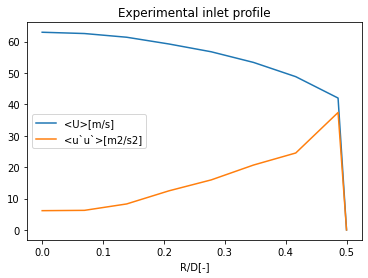

In [2]:
# Sandia D experimental valocity data for main jet inlet

path = 'D0_U.txt'
df = pd.read_csv(path, delim_whitespace=True, index_col=0)
# df.index = df.index * 7.2e-3
ax = df[0:0.5].plot()
ax.set_title('Experimental inlet profile')
plt.show()

In [3]:
np.random.seed(1)

def u_rms(r): # u_rms profile estimation from preprocess step of Sandia D flame
    return 2.07+1029*r

# Number of modes 
m_pos = 6     # rotating helical
m_zer = 2     # oscillating axisymmetric
m_neg = 0     # counter-rotating helical
m_total = m_pos + m_zer + m_neg

# A [m/s] - amplitude of a single mode, so the range for 1st mode is (-A[0]/2, A[0]/2)
k_A = np.sqrt(2.0/m_total) # Theoretical coefficient, to make total RMS = experimental 
#                          (check the theory in the beginning)
def fA(r):
    return k_A*u_rms(r)
# alpha [rad] - initial shift
alpha_pos = np.random.random(m_pos)*2*np.pi
alpha_zer = np.random.random(m_zer)*2*np.pi
alpha_neg = np.random.random(m_neg)*2*np.pi

# Psi [rad/s] - mode "velocity". How many rads/mode_number it will go in 1 s. For example 2pi rad/s 
#               -> full loop for 1st and half a loop for 2nd
# Important thing - Strouhal number St=Psi*L/U -> Psi = St*U/L = 0.55 * 50 / 0.0072 = 3820
# Psi = tuple(2*(i+1)*np.pi for i in range(m)) # all modes with the same velocity setup
# St_a = 0.55     # [-]   - Strouhal number for axisymmetric excitation (m=0), see [1,2]
# St_f = St_a/2   # [-]   - Strouhal number for helical excitation (m!=0), see [1,2]
St_a = 0.2     # [-]   - Strouhal number for axisymmetric excitation (m=0), see Wiki
St_f = 0.2   # [-]   - Strouhal number for helical excitation (m!=0), see Wiki
U  = 49.6       # [m/s] - Velocity at the inlet (experimental, probably based on mass flux)
L  = 7.2e-03    # [m]   - Characteristic length, main jet inlet diameter

Psi_pos = m_pos*[2*np.pi*St_f*U/L]
Psi_zer = m_zer*[2*np.pi*St_a*U/L]
Psi_neg = m_neg*[2*np.pi*St_f*U/L]

# Shifting frequencies, so they don'overlap
for i in range(m_pos):
    Psi_pos[i]*=(np.random.random()+0.5)*1.2
for i in range(m_zer):
    Psi_zer[i]*=(np.random.random()+0.5)*1.2
for i in range(m_neg):
    Psi_neg[i]*=(np.random.random()+0.5)*1.2


def oscill(r, phi, t):
    ux_oscill = 0
    A = fA(r)
    for i in range(m_neg):
#         print(f"neg mode {i}, u={A * np.sin(alpha_neg[i] - (i+1)*phi + Psi_neg[i]*t)}")
        ux_oscill += A * np.sin(alpha_neg[i] - (i+1)*phi + Psi_neg[i]*t)

    for i in range(m_zer):
#         print(f"zer mode {i}, u={A * np.sin(alpha_zer[i] + Psi_zer[i]*t)}")
        ux_oscill += A * np.sin(alpha_zer[i] + Psi_zer[i]*t)
    
    for i in range(m_pos):
#         print(f"pos mode {i}, u={A * np.sin(alpha_pos[i] + (i+1)*phi + Psi_pos[i]*t)}")
        ux_oscill += A * np.sin(alpha_pos[i] + (i+1)*phi + Psi_pos[i]*t)
    
    ux_oscill = np.where(r < 0.0035, ux_oscill, ux_oscill*(36-10000*r))
    ux_oscill[r>0.0036] = 0
    return ux_oscill

In [4]:
# Print report
print(f"k_A={k_A:.4}")
modes_df = pd.DataFrame(columns = ['m', 'alpha', 'Psi'])
for i in range(m_neg):
    modes_df = pd.concat([modes_df,pd.DataFrame.from_dict({'m':[-(i+1)], 'alpha':[alpha_neg[i]], 'Psi':[Psi_neg[i]]})], ignore_index=True)
for i in range(m_zer):
    modes_df = pd.concat([modes_df,pd.DataFrame.from_dict({'m':     [0], 'alpha':[alpha_zer[i]], 'Psi':[Psi_zer[i]]})], ignore_index=True)
for i in range(m_pos):
    modes_df = pd.concat([modes_df,pd.DataFrame.from_dict({'m':[+(i+1)], 'alpha':[alpha_pos[i]], 'Psi':[Psi_pos[i]]})], ignore_index=True)
modes_df.head(m_total)

k_A=0.5


m     alpha           Psi
0  0  1.170307   5478.607642
1  0  2.171222  12159.050247
2  1  2.620227   9315.799614
3  2  4.525932  10791.435693
4  3  0.000719   9548.776186
5  4  1.899612  12312.296868
6  5  0.922094   7317.990655
7  6  0.580181   14316.15915

In [5]:
%%capture
%matplotlib inline
################################
######### Plotting #############
################################
lx = 0.008
ly = 0.008
tolerance = 1e-08
D = 0.0072
R = D/2


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4), sharey=False)
# title = 'Induced artificial turbulence velocites\n'
# f.suptitle(title)

# On ax1 plot surface
x = np.arange(-lx/2, lx/2, 0.0001)
y = np.arange(-ly/2, ly/2, 0.0001)
x[np.abs(x) < tolerance] = tolerance
y[np.abs(y) < tolerance] = tolerance
xx, yy = np.meshgrid(x, y) #, sparse=True)
z = oscill(R/2, np.arctan2(xx,yy), 0.0001)
U_ampl = fA(R)*m_total
h = ax1.pcolor(xx*1000,yy*1000,z, vmin=-U_ampl, vmax=U_ampl, cmap=cm.seismic)
ax1.title.set_text('Induced artificial turbulence  velocities field')
ax1.set_aspect('equal')
f.colorbar(h, ax=ax1)
circle1 = plt.Circle((0, 0), 1000*R, color='k', fill=False)
circle2 = plt.Circle((0, 0), 1000*R/2, color='b', linestyle='-.', alpha=0.5, fill=False)
# ax1.plot(0, 0, R, 0, color='g', linestyle='--')
ax1.add_artist(circle1)
ax1.add_artist(circle2)
ax1.set_xlabel(r'$x, mm$')
ax1.set_ylabel(r'$y, mm$')
radius_location_ax1, = ax1.plot([0, 0], [0,-R*1000], color='g', linestyle='-.')

# On ax2 plot circle variation
ax2.title.set_text('Velocities at r=18mm (marked as a blue circle)')
ax2.axis([0,2*np.pi,-U_ampl,U_ampl])
ax2.set_xlabel(r'$\phi$')
ax2.set_ylabel(r'$U_{oscill}, m/s$')
ax2.set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3/2 \pi$', r'$2 \pi$'])
ax2.set_xticks([0.0, 0.5*np.pi, 1.0*np.pi, 1.5*np.pi, 2.0*np.pi])
ax2.grid(True)
ang_plot, = ax2.plot([],[], color='cornflowerblue')
radius_location, = ax2.plot([np.pi, np.pi], [-U_ampl,U_ampl], color='g', linestyle='-.')

# On ax3 plot variation along radius
ax3.title.set_text(r'Velocities at $\phi=\pi$ (marked as a green line)')
line_plot, = ax3.plot([],[], color='g')
ax3.axis([0,R*1000,-U_ampl,U_ampl])
ax3.set_xlabel(r'$r, mm$')
ax3.set_ylabel(r'$U_{oscill}, m/s$')
ax3.grid(True)
circle_location, = ax3.plot([1000*R/2, 1000*R/2], [-U_ampl,U_ampl], color='cornflowerblue', linestyle='-.')

text_time = ax2.text(0.9, 0.95, 't=0ms', horizontalalignment='center',verticalalignment='center', transform=ax2.transAxes)
# text_modes = ax2.text(0.03, 0.95, f'Nmodes={m_total}', horizontalalignment='left',verticalalignment='center', transform=ax2.transAxes)
# text_st = ax2.text(0.03, 0.90, 'Strouhal number=0.1..1', horizontalalignment='left',verticalalignment='center', transform=ax2.transAxes)
text_nozzle = ax1.text(0.85, 0.085, 'main jet nozzle', horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes)
text_nozzle1 = ax1.text(0.85, 0.04, 'd=7.2mm', horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes)

# for ax1
times = np.arange(0,0.01,1e-4)
phis = np.arctan2(xx,yy)
rs = np.sqrt(xx**2 + yy**2)
# for ax2
phi_circle = np.arange(0, 2*np.pi, np.pi/20)
# for ax3
r_line = np.arange(0, R, 0.0001)


def animate(t):
    # ax1
    z = oscill(rs, phis, t)
    # h.set_array(z[:-1,:-1].ravel())
    h.set_array(z.ravel())
    # ax2
    ang_plot.set_data(phi_circle, oscill(0.0036/2, phi_circle, t))
    text_time.set_text(f't={round(t*1000,1)}ms') 
    # ax3
    line_plot.set_data(1000*r_line, oscill(r_line, np.pi, t))

ani = matplotlib.animation.FuncAnimation(f, animate, frames=times)

In [6]:
from IPython.display import display, HTML
display(HTML(ani.to_jshtml()));

In [34]:
Writer = matplotlib.animation.writers['ffmpeg']
writer = Writer(fps=12, metadata=dict(artist='Me'), bitrate=1800)

ani.save('Danaila_and_Boersma.mp4', writer=writer)

/tmp/ipykernel_169/2704457419.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3/2 \pi$', r'$2 \pi$'])


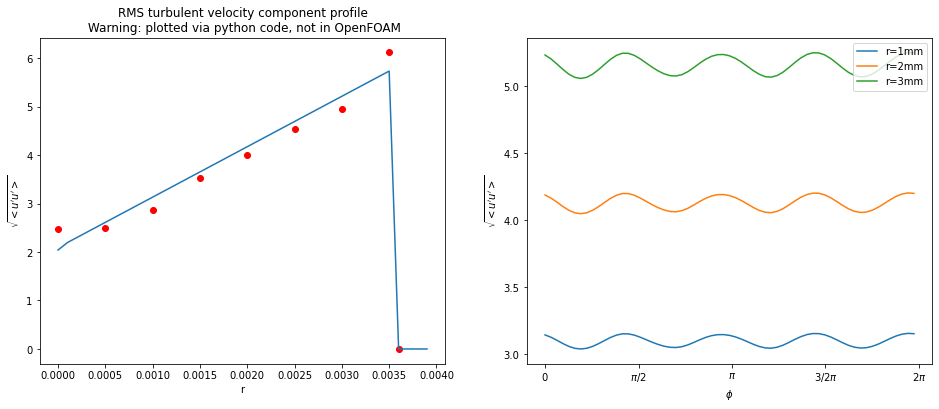

In [7]:
# Numerical RMS

# On radius
squared_sum = np.zeros(xx.shape)
times = np.arange(0,1,1e-3)
# r = np.arange(0,0.0036,1e-4)
rs = np.sqrt(xx**2 + yy**2)
phis = np.arctan2(xx,yy)
for t in times:
    squared_sum += oscill(rs, phis, t)**2
RMS = np.sqrt(squared_sum/len(times))

# On circle
phis = np.arange(0,2*np.pi,0.1)
times = np.arange(0,1,1e-3)
squared_sum_r10 = np.zeros(phis.shape)
squared_sum_r20 = np.zeros(phis.shape)
squared_sum_r30 = np.zeros(phis.shape)

for t in times:
#     print(oscill(1e-3, phis, t))
    squared_sum_r10 += oscill(1e-3, phis, t)**2
    squared_sum_r20 += oscill(2e-3, phis, t)**2
    squared_sum_r30 += oscill(3e-3, phis, t)**2
RMS_r10 = np.sqrt(squared_sum_r10/len(times))
RMS_r20 = np.sqrt(squared_sum_r20/len(times))
RMS_r30 = np.sqrt(squared_sum_r30/len(times))



fig, ax = plt.subplots(ncols=2,figsize=(16,6))
ax[0].plot(x[40:], pd.DataFrame(RMS).loc[40,40:], label=f'my fixedCodedValue BC with {m_total} sine modes')
ax[0].scatter(df[0:0.5].index*7.2/1000, np.sqrt(df[0:0.5]['<u`u`>[m2/s2]']), label='experimental profile', color='r')
ax[0].set_xlabel('r')
ax[0].set_ylabel(r"$\sqrt{<u'u'>}$")
ax[0].set_title('RMS turbulent velocity component profile\n Warning: plotted via python code, not in OpenFOAM')

ax[1].plot(phis, RMS_r10, label='r=1mm')
ax[1].plot(phis, RMS_r20, label='r=2mm')
ax[1].plot(phis, RMS_r30, label='r=3mm')
ax[1].set_xticklabels([r'$0$', r'$\pi/2$', r'$\pi$', r'$3/2 \pi$', r'$2 \pi$'])
ax[1].set_xticks([0.0, 0.5*np.pi, 1.0*np.pi, 1.5*np.pi, 2.0*np.pi])
ax[1].set_xlabel(r'$\phi$')
ax[1].set_ylabel(r"$\sqrt{<u'u'>}$")


plt.legend()
plt.show()

# Tests

In [8]:
y = 0.001
z = 0.002
t = 0.3

phi = np.arctan2(y,z)
r = np.sqrt(y**2 + z**2)

uturb = oscill(r, phi, t)
print(uturb)

umean = 14.21124*(np.log10(-r+1.48011e-07+0.0036)-np.log10(1.48011e-07));

print(umean + uturb)

2.3753784828240248
58.71649117916307
